# Molecular properties
## Structure optimization

One of the most commonly calculated properties in theoretical chemistry is the molecular structure. It is quite common to use structures calculated at a cheaper level of theory, typically DFT, as a starting point since ground state energies are relatively insensitive to the geometry. However, in some cases, especially when strong correlation is significant, one may want to use MCSCF structures instead.

The workflow here is very similar to that of VeloxChem, namely first defining the Gradient Driver, and then give it to the optimizer, which itself is based on GeomeTRIC. The MCSCF gradient driver will automatically choose analytical gradients if available for the specific type of MCSCF calculation performed, numerical gradients otherwise.

```{note}
Currently, derivative integrals are not available and all gradients are therefore numerical. This should change very soon.
```

Let's illustrate this on a simple O$_2$ molecule. First, we compute one MCSCF with the $\pi$ orbitals in the active space.

In [1]:
import veloxchem as vlx
import multipsi as mtp

O2_xyz="""2

O 0.0 0.0 -0.6
O 0.0 0.0  0.6
"""
molecule=vlx.Molecule.from_xyz_string(O2_xyz)
molecule.set_multiplicity(3)
basis = vlx.MolecularBasis.read(molecule,"cc-pvdz")

scfdrv = vlx.ScfUnrestrictedDriver()
scfdrv.compute(molecule, basis)
uhf_orbs = scfdrv.natural_orbitals()

space=mtp.OrbSpace(molecule,uhf_orbs)
space.CAS(6,4)
mcscfdrv=mtp.McscfDriver()
mcscfdrv.compute(molecule,basis,space)

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 16.
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Unrestricted Hartree-Fock                                       
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Erro


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 5
Number of active orbitals:              4
Number of virtual orbitals:             19

    This is a CASSCF wavefunction: CAS(6,4)

          CI expansion:
          -------------
Number of determinants:      6


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -149.645938143     0.0e+00      5.7e-02          1   0:00:00
        2     -149.646679509    -7.4e-04      1.8e-02          1   0:00:00
        3     -149.646744537    -6.5e-05      3.6e-03          1   0:00:00
      

                                                                                                                          
Total MCSCF time: 00:00:00


Now, we optimize the molecule.

In [2]:
GradDrv=mtp.McscfGradientDriver(mcscfdrv)
opt_drv = vlx.OptimizationDriver(GradDrv)
casscf_opt_geom = opt_drv.compute(molecule, basis, space)

                                                                                                                          
                                                Optimization Driver Setup                                                 
                                                                                                                          
                                     Coordinate System       :    TRIC                                                    
                                     Constraints             :    No                                                      
                                     Max. Number of Steps    :    300                                                     
                                     Transition State        :    No                                                      
                                     Hessian                 :    never                                                   
                

We can now use this new geometry in subsequent calculations.

In [3]:
molecule=casscf_opt_geom
mcscfdrv.compute(molecule,basis,space)


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 5
Number of active orbitals:              4
Number of virtual orbitals:             19

    This is a CASSCF wavefunction: CAS(6,4)

          CI expansion:
          -------------
Number of determinants:      6


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -149.647278689     0.0e+00      9.8e-06          1   0:00:00
                                                                                                                          
** Convergence reached in 1 itera

                                                                                                                          
Total MCSCF time: 00:00:00


If your MCSCF calculation is a state-averaged, you should extend the parameters of the compute function with the number of states in the state-averaging and the index (starting from 0) of the state you wish to optimize:

```
casscf_opt_geom = opt_drv.compute(molecule, basis, space, nstates, istate)
```

## Spectroscopy

### State-averaging

MCSCF is commonly used to simulate spectroscopy and photochemistry. There are several ways to compute excited state properties from a MCSCF calculation. As discussed in the previous section, one way is to use state-averaging:

Let's go back to our furan calculation. First we compute a SA-CASSCF with 5 states:

In [4]:
furan_xyz="""9

 C     -0.86213    -0.90784     0.00007
 H     -1.63433    -1.64264    -0.00003
 C      0.50727    -0.90524     0.00007
 C      0.92057     0.47886    -0.00003
 C     -0.22323     1.23186    -0.00003
 O     -1.35123     0.40376    -0.00013
 H      1.17117    -1.74724     0.00017
 H      1.93767     0.81866     0.00007
 H     -0.46573     2.26986    -0.00013
"""

molecule = vlx.Molecule.from_xyz_string(furan_xyz)
basis = vlx.MolecularBasis.read(molecule,"def2-sv(p)")

#We use a previously stored h5 file for the active space
space=mtp.OrbSpace(molecule,"furan-cas.h5")
mcscfdrv=mtp.McscfDriver()
mcscfdrv.compute(molecule,basis,space, 5) #state-averaged with 5 states


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 15
Number of active orbitals:              5
Number of virtual orbitals:             58

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -228.211383987     0.0e+00      1.6e-01          1   0:00:00
        2     -228.223997559    -1.3e-02      8.1e-02          1   0:00:00
        3     -228.226393803    -2.4e-03      1.8e-02          1   0:00:00
    

                                                                                                                          
Total MCSCF time: 00:00:01


Now we can compute the transition properties using the InterState module. This module requires the CI vectors computed by the MCSCF.

In [5]:
#Compute oscillator strengths
SI=mtp.InterState()
Prop_dict=SI.diposc(molecule,basis,mcscfdrv.CIVecs)

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        6.66708         3.935228e-03    2.925456e-03
     1       3        8.29230         2.426600e-01    1.672872e-01
     1       5       10.11827         5.706685e-01    4.028088e-01


The function returns a dictionary with the most important values.

In [6]:
print(Prop_dict["energies"])
print(Prop_dict["oscillator_strengths"])

[0.24501075 0.30473646 0.35263678 0.37183941]
[3.93522815e-03 2.42660014e-01 8.35432666e-25 5.70668499e-01]


By default InterState computes properties from the first state to all others, but this can be changed by providing the list of "initial" and "final" states as arguments.

In [7]:
Prop_dict=SI.diposc(molecule,basis,mcscfdrv.CIVecs, ifrom=[0,1], ito='all' )

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        6.66708         3.935228e-03    2.925456e-03
     1       3        8.29230         2.426600e-01    1.672872e-01
     1       5       10.11827         5.706685e-01    4.028088e-01
     2       3        1.62522         2.610885e-02    2.178061e-02
     2       5        3.45118         1.364278e-03    1.798930e-04


The diposc function is a shortcut to the compute function that takes a list of properties as argument. Thus it is equivalent to calling

```
Prop_dict = SI.compute(molecule,basis, mcscfdrv.CIVecs, ["absorption"], [0,1], 'all')
```

The list of properties can also accept 'ecd' to compute electric circular dichroism.

```
Prop_dict = SI.compute(molecule,basis, mcscfdrv.CIVecs, ["absorption", "ecd"], [0,1], 'all')
```
which adds "rotatory_strengths" to the dictionary. There is also a shortcut function to compute only the ECD spectrum:

```
Prop_dict = SI.ecd(molecule,basis, mcscfdrv.CIVecs)
```

### Linear response

Another way to compute excited state properties at the MCSCF level is using linear response. This multiconfigurational linear response (MCLR) requires first a MCSCF calculation of the ground state and then the use of the Mclr_EigenSolver module:

In [8]:
mcscfdrv=mtp.McscfDriver()
mcscfdrv.compute(molecule,basis,space) #only ground state!

mcrpa = mtp.Mclr_EigenSolver()
Prop_dict = mcrpa.compute(molecule,basis,mcscfdrv,nstates = 5)


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 15
Number of active orbitals:              5
Number of virtual orbitals:             58

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -228.481333003     0.0e+00      1.0e-01          1   0:00:00
        2     -228.487054041    -5.7e-03      4.6e-02          1   0:00:00
        3     -228.487922618    -8.7e-04      1.8e-02          1   0:00:00
    

                                                                                                                          
Total MCSCF time: 00:00:01
                                                                                                                          
Initialization time: 00:00:00
                                                                                                                          
          Linear eigensolver
          ------------------
                                                                                                                          
CI parameters:      54
Orbital parameters: 1235
                                                                                                                          
                                                                                                                          
                                                                                                   

Again, the Prop_dict dictionary gives us access to the most important values. It is also possible to get an analysis of the dominant excitation character using the command:

In [9]:
mcrpa.get_excitation_character()

                                                                                                                          
    Excitation characters
    ---------------------
                                                                                                                          
* State 1
- Exc. energy: 0.24232834425610308
 Electrons     Excitation
 0.344    :   17  ->   19
 0.260    :   18  ->   20
 CI weight: 0.971  Orb weight: 0.029
                                                                                                                          
* State 2
- Exc. energy: 0.2712909003241148
 Electrons     Excitation
 0.906    :   18  ->   19
 CI weight: 0.928  Orb weight: 0.072
                                                                                                                          
* State 3
- Exc. energy: 0.3257754793888528
 Electrons     Excitation
 0.303    :   18  ->   20
 0.264    :   17  ->   19
 0.241    :   16  ->   19
 CI weight: 0.9

In this analysis, we can see one of the most attractive feature of linear response compared to state-averaging: linear response also includes excitation from or to non-active orbitals. In this example, state 4 and 5 include excitations from the $\pi$ orbitals to some higher lying $\sigma$ orbitals. This feature is particularily useful for molecules with heteroatom lone pairs which do not contribute to the correlation in the active space (and are often difficult to keep in it) but often contribute to some of the lowest-lying excitations.

Another advantage of linear response is that unlike state-averaging, the excitation energies does not depend on the number of calculated states (except when the code accidentally converges to a higher solution, in which case increasing the number of states tends to ensure we get actually the lowest ones). Overall, in most cases, linear response provides more accurate excitation energies than state-averaging.

Note that the Tamm-Dancoff approximation is also available (using the property "mcrpa.TDA = True") which gives a slightly faster but less accurate calculation.

### Complex linear response

It is possible to compute linear response solutions not by explicitely solving for all states but by instead computing the total response function at a given frequency of light. While the 2 approaches give the same results, the latter can be advantageous computationally when there is a high density of states or if one is interested in high frequencies, for example X-rays. To avoid the divergence at resonance, we introduce an imaginary damping factor, corresponding to the finite lifetime of the states, and effectively introducing a broadening of the spectra. The resulting equations become complex and one usually speaks of complex response or the complex polarization propagator.

Multipsi includes such a solver. It requires both the damping factor and the range of frequencies of interest. By default, the solver computes the absorption (length gauge), but other linear properties are available, including circular dichroism and other gauges.

In [17]:
# Oxygen K-edge spectrum of furan
cpp = mtp.Mclr_CPPsolver()
cpp.set_damping(0.1) # Damping term in eV 
cpp.set_frequency_range(550,558,step_size = 0.1) # uniform frequency distribution between 550 and 558 eV with 0.1 eV grid
Prop_dict = cpp.compute(molecule,basis,mcscfdrv)

        ╭────────────────────────────────────────────────────╮
        │     Complex polarization propagator calculation    │
        ╰────────────────────────────────────────────────────╯
          a Operator              : dipole
          b Operator              : dipole

          CI parameters           : 55                          
          Orbital parameters      : 1235                        
          Tamm-Dancoff Approx.    : yes                         
                                                              
          Frequencies             : 80                          
          Frequency range         : 550.00 -> 557.90 eV           
          Spatial dimensions      : xyz                         
          Response equations      : 240                         
                                                              
          Damping                 : 0.00367 a.u. 0.1000 eV      
          Conv. threshold         : 1.0e-03                     
          L

                                                                                                                          
                                                                                                                          
         
TDA Linear absorption cross-section (a.u.)
  ┌------------------------------------------------------------┐
  │                                                            │
  │                                                            │
  │                             x                              │
  │                             x                              │
  │                             x                              │
  │                             x                              │
  │                             x                              │
  │                             x                              │
  │                             x                              │
  │                             x                  

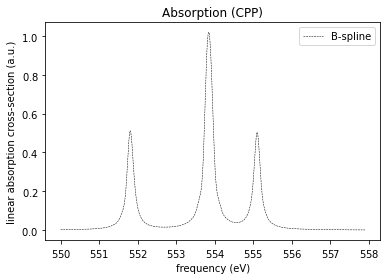

In [18]:
cpp.produce_plot(show_plot = True,save_plot = False)